In [1]:
import requests
import argparse
import tarfile
import os
import cv2
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                

### Datasets loading from google drive

 Brain Tumor

In [ ]:
%%time
file_id = '1A2IU8Sgea1h3fYLpYtFb2v7NYdMjvEhU'
destination = 'BrainTumor.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('BrainTumor.tar', mode='r')
f.extractall()
f.close()

os.remove('BrainTumor.tar')

Heart

In [ ]:
%%time
file_id = '1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY'
destination = 'Heart.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('Heart.tar', mode='r')
f.extractall()
f.close()
os.remove('Heart.tar')

CPU times: user 719 ms, sys: 1.13 s, total: 1.85 s
Wall time: 3.03 s


Hippocampus

In [ ]:
%%time
file_id = '1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C'
destination = 'Hippocampus.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('Hippocampus.tar', mode='r')
f.extractall()
f.close()
os.remove('Hippocampus.tar')

CPU times: user 60.3 ms, sys: 57.3 ms, total: 118 ms
Wall time: 5.76 s


Liver

In [ ]:
%%time
file_id = '1jyVGUGyxKBXV6_9ivuZapQS8eUJXCIpu'
destination = 'Liver.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('Liver.tar', mode='r')
f.extractall()
f.close()
os.remove('Liver.tar')

Prostate

In [ ]:
%%time
file_id = '1Ff7c21UksxyT4JfETjaarmuKEjdqe1-a'
destination = 'Prostate.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('Prostate.tar', mode='r')
f.extractall()
f.close()
os.remove('Prostate.tar')

CPU times: user 305 ms, sys: 556 ms, total: 861 ms
Wall time: 9.7 s


Lung

In [ ]:
%%time
file_id = '1I1LR7XjyEZ-VBQ-Xruh31V7xExMjlVvi'
destination = 'Lung.tar'
download_file_from_google_drive(file_id, destination)

f = tarfile.open('Lung.tar', mode='r')
f.extractall()
f.close()
os.remove('Lung.tar')

CPU times: user 11.7 s, sys: 19.2 s, total: 30.9 s
Wall time: 1min 4s


Pancreas

In [ ]:
%%time
#file_id = '1YZQFSonulXuagMIfbJkZeTFJ6qEUuUxL'
#destination = 'Pancreas.tar'
#download_file_from_google_drive(file_id, destination)

f = tarfile.open('Pancreas.tar', mode='r')
f.extractall()
f.close()
os.remove('Pancreas.tar')

CPU times: user 27.5 s, sys: 50.6 s, total: 1min 18s
Wall time: 3min 59s


___

Load test image and save it as .bmp image

In [ ]:
%%time
img = nib.load('./Task07_Pancreas/imagesTr/pancreas_001.nii.gz').get_fdata()
mask = nib.load('./Task07_Pancreas/labelsTr/pancreas_001.nii.gz').get_fdata()
print(img.shape)
print(mask.shape)
print(np.unique(mask))

(512, 512, 110)
(512, 512, 110)
CPU times: user 894 ms, sys: 215 ms, total: 1.11 s
Wall time: 1.13 s


In [ ]:
cv2.imwrite('test.bmp', img[:,:,32])

True

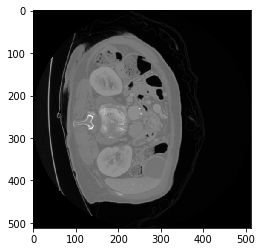

In [ ]:
cv2.imwrite('test.bmp', norm_img)
plt.imshow(cv2.imread('test.bmp', 0), cmap='gray')

In [ ]:
# calculate z-dimensions of images in dataset
# and average number of slices per image that 
# have something on it
img_paths = sorted(glob('./Task07_Pancreas/imagesTr/*.gz'))
mask_paths = sorted(glob('./Task07_Pancreas/labelsTr/*.gz'))
z, mean_pos_slices = [], []
mask_shapes = []
for idx in range(len(img_paths)):
    img = nib.load(img_paths[idx]).get_fdata()
    mask = nib.load(mask_paths[idx]).get_fdata()
    z.append(img.shape[2])
    mask_shapes.append(mask.shape)
    pos_slices = 0
    
    for k in range(z[idx]):
        if mask[:, :, k].sum() > .0:
            pos_slices += 1
    
    mean_pos_slices.append(pos_slices / z[idx])

In [ ]:
plt.hist(z, bins=100)
plt.suptitle('Number of slices per patient');

In [ ]:
plt.hist(mean_pos_slices, bins=100)
plt.suptitle('Fraction of slices with deseases per one patient');

### Convert all images in some image format (like \*.bmp) and save it

In [2]:
def convert_range(image, max_value, min_value):

    image = np.round((image - min_value) / (max_value - min_value))

    return image

def get_correct_idx(idx, max_digits):
    idx_string = '0'*max_digits
    i = len(str(idx))
    return idx_string[:-i] + str(idx)

def transform_data(source, destination, format='bmp'):
    """
    This function converts original dataset, which is a collection of
    3D images and 3D masks in .nii format to 2D images and masks in .bmp format.
    Each image/mask corresponds to  a slice of 3D image

    :param source: path to the original dataset root directory, str
    :param destination: path to the root directory of transformed dataset, str
    :param format: format of output images, str
    :return: None
    """

    img_paths = sorted(glob(os.path.join(source, 'imagesTr/*.gz')))
    mask_paths = sorted(glob(os.path.join(source, 'labelsTr/*.gz')))

    if not os.path.exists(os.path.join(destination, 'images')):
        os.makedirs(os.path.join(destination, 'images'))

    if not os.path.exists(os.path.join(destination, 'masks')):
        os.makedirs(os.path.join(destination, 'masks'))

    for idx in range(len(img_paths)):
        img = nib.load(img_paths[idx]).get_fdata()
        mask = nib.load(mask_paths[idx]).get_fdata().astype(np.uint8)

        num_slices = img.shape[2]
        for slice_n in range(num_slices):
            img_slice = img[:, :, slice_n]
            img_slice = convert_range(img_slice, np.max(img_slice), np.min(img_slice))
            mask_slice = mask[:, :, slice_n]

            # save image and mask
            idx_str = get_correct_idx(idx, len(str(len(img_paths))))
            slice_n_str = get_correct_idx(slice_n, len(str(num_slices)))
            cv2.imwrite(os.path.join(destination, 'images', f'{idx_str}_{slice_n_str}.{format}'), img_slice)
            np.savez(os.path.join(destination, 'masks', f'{idx_str}_{slice_n_str}'), mask_slice)

def transform_data_3d(source, destination):
    img_paths = sorted(glob(os.path.join(source, 'imagesTr/*.gz')))
    mask_paths = sorted(glob(os.path.join(source, 'labelsTr/*.gz')))

    if not os.path.exists(os.path.join(destination, 'images')):
        os.makedirs(os.path.join(destination, 'images'))

    if not os.path.exists(os.path.join(destination, 'masks')):
        os.makedirs(os.path.join(destination, 'masks'))
    
    for idx in range(len(img_paths)):
        img = nib.load(img_paths[idx]).get_fdata()
        mask = nib.load(mask_paths[idx]).get_fdata().astype(np.uint8)
        idx_str = get_correct_idx(idx, len(str(len(img_paths))))
        
        np.savez(os.path.join(destination, 'images', f'{idx_str}'), img)
        np.savez(os.path.join(destination, 'masks', f'{idx_str}'), mask)
        
def split_data(path, split_ratio=0.15):
    """
    Makes .csv file with columns 'ImageId'/'ImageName', 'Fold', where
    the last column contains zeros and ones. For rows with ones in 'Fold'
    column the corresponding image will be put in holdout set for validation

    :param path: path to directory with images, str
    :param split_ratio: ratio between train and validation set, float
    :return: None
    """
    img_names = sorted(os.listdir(path + '/images'))
    img_names = list(map(lambda x: x.split('.')[0], img_names))
    img_names = np.array(img_names).reshape(-1, 1)
    m = len(img_names)
    folds = np.zeros((m, 1), dtype=np.uint8)
    val_idxs = np.random.choice(m, size=int(split_ratio * m), replace=False)
    folds[val_idxs] = 1
    
    data = np.hstack((img_names, folds))
    df = pd.DataFrame(data, columns=['ImageId', 'fold'])
    df['fold'] = pd.to_numeric(df['fold'])
    df.to_csv(os.path.join(path, 'folds.csv'))
    return df

In [11]:
SOURCE = './Task07_Pancreas'
DEST = './dataset-3d'

In [12]:
%%time
transform_data_3d(SOURCE, DEST)
print('Dataset transformed successfully!', end='\n\n')

OSError: [Errno 28] No space left on device

In [13]:
%%time
df = split_data(DEST, split_ratio=0.15)
print('folds.csv created successfully!', end='\n\n')

OSError: [Errno 28] No space left on device

In [6]:
df.dtypes

ImageId    object
fold        int64
dtype: object

In [7]:
df.loc[df['fold'] != 1, 'ImageId'].values

array(['000_001', '000_002', '000_003', ..., '280_126', '280_128',
       '280_129'], dtype=object)

In [8]:
df.columns

Index(['ImageId', 'fold'], dtype='object')

### Testing transformed dataset

True
000_041


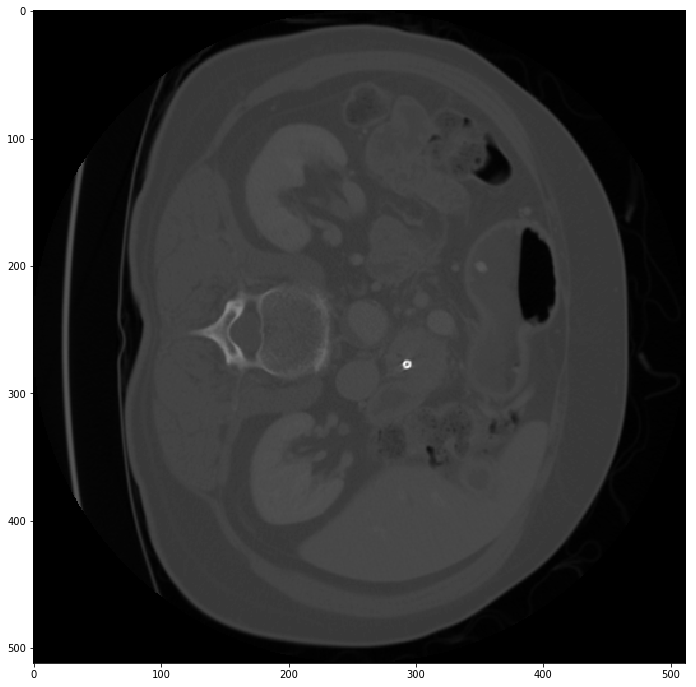

In [21]:
img_name = df['ImageId'][41]
print(os.path.exists(f'./dataset/images/{img_name}.bmp'))
print(img_name)
img = cv2.imread(f'./dataset/images/{img_name}.bmp', 0)
#mask = np.load(f'./dataset/masks/{img_name}.npz')['arr_0']

#img = cv2.addWeighted(mask, alpha, img, 1 - alpha, 0, img)
plt.figure(figsize=(15, 12))
plt.imshow(img, cmap='gray');

True
000_041


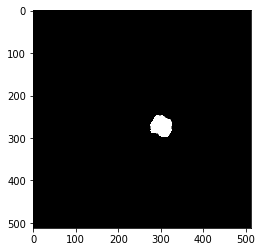

In [12]:
img_name = df['ImageId'][41]
print(os.path.exists(f'./dataset/masks/{img_name}.npz'))
print(img_name)
mask = np.load(f'./dataset/masks/{img_name}.npz')['arr_0']
plt.imshow(mask, cmap='gray');

In [8]:
np.unique(mask)

array([0, 1, 2], dtype=uint8)